In [ ]:
!pip install pandas-datareader
!pip install yfinance

In [ ]:
!pip install prophet

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from pandas_datareader import data
import yfinance as yf
yf.pdr_override()

Input the stock sticker

In [ ]:
sticker_name = str(input())

TSLA


Input the start and end date
Format = YYYY-MM-DD

In [ ]:
s = str(input("start day = "))
e = str(input("end day = "))

start day = 2020-12-31
end day = 2022-12-31


In [ ]:
stock = data.DataReader(sticker_name, start = s, end = e)
stock.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,233.330002,239.573334,230.373337,235.223328,235.223328,148949700
2021-01-04,239.820007,248.163330,239.063339,243.256668,243.256668,145914600
2021-01-05,241.220001,246.946671,239.733337,245.036667,245.036667,96735600
2021-01-06,252.830002,258.000000,249.699997,251.993332,251.993332,134100000
2021-01-07,259.209991,272.329987,258.399994,272.013336,272.013336,154496700


## Data Visualization

In [ ]:
import plotly.express as px
import plotly.io as pio
pio.renderers.default='colab'

In [ ]:
px.area(stock, x = stock.index, y = 'Close', title = "Closing Price History")

In [ ]:
px.box(stock, y = 'Close', title = "5-Number Summary of Closing Price")

In [ ]:
px.line(stock, y = 'Volume', title = "Volume History")

## Approach 1: Sklearn Regression Model

Predict the average opening price of the next five trading days using the opening price of today

In [ ]:
today = np.array(stock['Open'].iloc[:-5])
next = np.array(stock['Open'].iloc[1:])

avg = [np.mean(next[i:i+5]) for i in range(len(today))]
today = today.reshape(-1, 1)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
x_train, x_test, y_train, y_test = train_test_split(today, avg, test_size=0.2)

In [ ]:
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)

## Scatter plot between y_test and y_pred



Text(0.5, 1.0, 'y_test ~ y_pred')

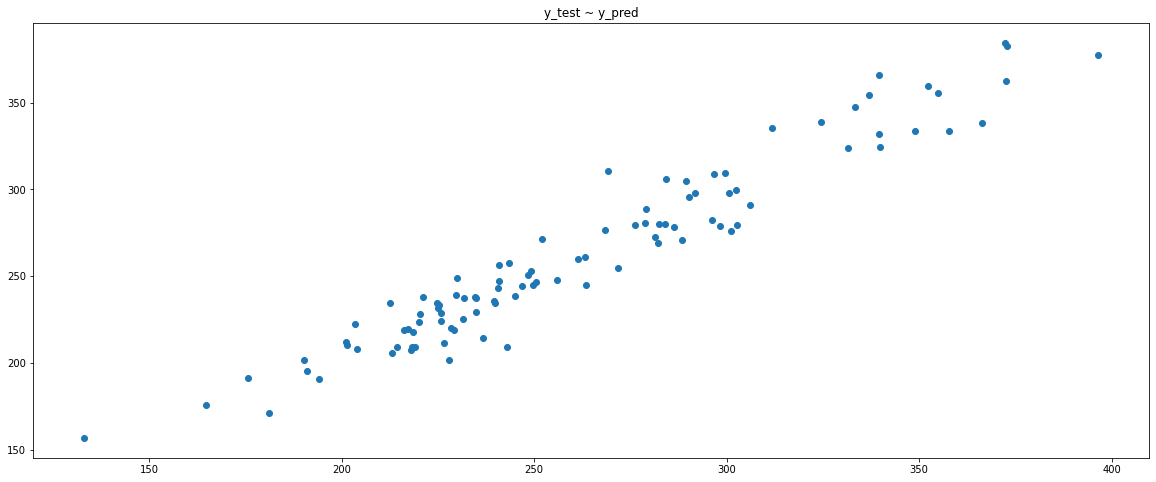

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plt.scatter(y_test, y_pred)
plt.title("y_test ~ y_pred")

Metrics

In [ ]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean squared error = {mse}")
print(f"R2 = {r2}")

Mean squared error = 185.23087402754882
R2 = 0.9326311855644864


In [ ]:
n = int(input('Number of trading days to be predicted = '))

Number of trading days to be predicted = 100


## Comparison of predicted data and real data

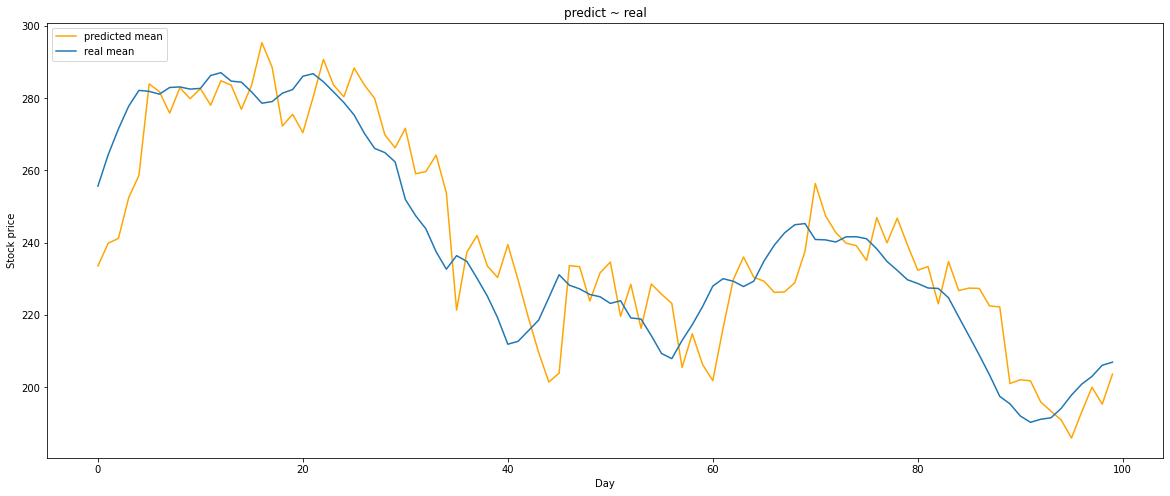

In [ ]:
plt.figure(figsize=(20,8))
pred = reg.predict(today[:n])
plt.plot(pred, label='predicted mean', color='orange')
plt.plot(avg[:n], label='real mean')
plt.title("predict ~ real")
plt.xlabel("Day")
plt.ylabel("Stock price")
plt.legend(loc=2)

## Approach 2: Facebook Prophet Model

In [ ]:
from prophet import Prophet

In [ ]:
pdf = stock.copy().drop(['Open','High', 'Low', 'Adj Close', 'Volume'], axis = 1)

In [ ]:
pdf['Date'] = pdf.index
pdf.rename(columns={"Close": "y", "Date": "ds"}, inplace = True)
pdf.head()

,y,ds
Date,,
2020-12-31,235.223328,2020-12-31
2021-01-04,243.256668,2021-01-04
2021-01-05,245.036667,2021-01-05
2021-01-06,251.993332,2021-01-06
2021-01-07,272.013336,2021-01-07


In [ ]:
pmodel = Prophet()
pmodel.fit(pdf)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwl94xah/1lc98ged.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmprwl94xah/1dczvtrh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75702', 'data', 'file=/tmp/tmprwl94xah/1lc98ged.json', 'init=/tmp/tmprwl94xah/1dczvtrh.json', 'output', 'file=/tmp/tmprwl94xah/prophet_model3_q_1obs/prophet_model-20230104092037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:20:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:20:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
new_data = pmodel.make_future_dataframe(periods = 30)
predict = pmodel.predict(new_data)
predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-12-31,262.548479,222.438757,309.672701,262.548479,262.548479,4.391037,4.391037,4.391037,4.391037,4.391037,4.391037,0.0,0.0,0.0,266.939516
1,2021-01-04,260.958137,231.692042,311.801307,260.958137,260.958137,7.734531,7.734531,7.734531,7.734531,7.734531,7.734531,0.0,0.0,0.0,268.692668
2,2021-01-05,260.560551,226.340380,305.455797,260.560551,260.560551,5.621695,5.621695,5.621695,5.621695,5.621695,5.621695,0.0,0.0,0.0,266.182246
3,2021-01-06,260.162966,227.544684,305.309823,260.162966,260.162966,6.240673,6.240673,6.240673,6.240673,6.240673,6.240673,0.0,0.0,0.0,266.403639
4,2021-01-07,259.765381,226.909148,305.695507,259.765381,259.765381,4.391037,4.391037,4.391037,4.391037,4.391037,4.391037,0.0,0.0,0.0,264.156418


In [ ]:
px.line(predict, x = 'ds', y = ['trend','yhat'], title = 'Predicted Closing Price')

The black dots are the actual prices. The predicted values are in blue.
The blue region represents the difference of yhat upper and yhat lower.
There exists a good buying opportunity if the black dot is under the blue line, and vice versa.

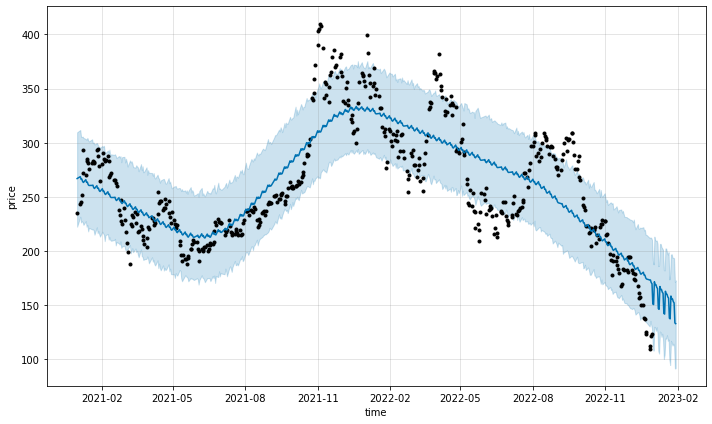

In [ ]:
fig = pmodel.plot(predict, xlabel = 'time', ylabel = 'price')